<a href="https://colab.research.google.com/github/ykitaguchi77/GO_AI_project/blob/main/YOLOv8_to_EfficientNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**YOLOv8 to EfficientNetv2 pipeline**

#**Olympia datasetから目を切り抜く（YOLOv8n）**
#**切り抜いた目をEfficientNetV2で解析する**

In [ ]:
"""
Olympia dataset
Dlibで目が2つ検出されるものを抜き出す
YOLOv8を用いて左右とバウンディングボックスを認識させる
切り抜いたバウンディングボックス内の画像について、EfficientNetv2を用いて眼球突出度、MRD-1、MRD-2を回帰させる
スマホに実装
"""

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import shutil
import copy
import pandas as pd
import csv
from tqdm import tqdm

import glob
import random
from PIL import Image
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#親フォルダ
parent_dir = '/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv8'

#元画像フォルダ
dataset_dir = '/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset'

#元画像をコピー
orig_dir = f"{parent_dir}/dataset_orig"

#切りぬいた画像を保存するフォルダ
out_dir = f"{parent_dir}/dataset_uni"

#CSVファイルのフォルダ
csv_path = f"{parent_dir}/dataset_uni_for_YOLO8.csv"

In [ ]:
# parent_dirがあれば削除する
if os.path.exists(parent_dir):
    shutil.rmtree(parent_dir)

# 新しくparent_dirを作成する
os.makedirs(parent_dir)

# orig_dir, out_dirを新規に作成する
os.makedirs(orig_dir)
os.makedirs(out_dir)

# orig_dirにdataset_dir直下のファイルをすべてコピーする
file_list = os.listdir(dataset_dir)
for filename in tqdm(file_list, desc="Copying files", unit="file"):
    src_path = os.path.join(dataset_dir, filename)
    dst_path = os.path.join(orig_dir, filename)
    shutil.copy(src_path, dst_path)

print("処理が完了しました。")


Copying files: 100%|██████████| 1016/1016 [00:53<00:00, 19.03file/s]

処理が完了しました。


#**HaarCascadeを用いて目を検出**

In [ ]:
# カスケードファイルのパス
eye_cascade_path = '/content/drive/My Drive/Deep_learning/haarcascade_eye.xml'

# カスケード分類器の特徴量取得
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)


#**目が2つ以上検出されたものを抜き出す**

In [ ]:
with open(csv_path, 'w', newline='') as f:
        #fieldnames = ['Number', 'Folder', 'FileName']
        writer = csv.writer(f)
        writer.writerow(['id','img_path', 'side R/L', 'ex', 'ey', 'ew', 'eh'])  #header

        files = os.listdir(orig_dir)

        k=0
        for file in files:  #フォルダ数の分だけ
              file_path = f"{orig_dir}/{file}"
              id = os.path.splitext(os.path.basename(file_path))[0]

              img = cv2.imread(file_path)
              img2 = img.copy()

              # 画像グレースケール化
              grayscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

              #300pix以上のもので目に見えるものを抽出
              eye_list = eye_cascade.detectMultiScale(grayscale_img, minSize=(300, 300))

              # 眼検出判定
              if len(eye_list) >= 1:
                  print('目が' + str(len(eye_list)) +'個検出されました')
              else:
                  print("eye detection error")

              #画像の切り抜きと保存（2個以上検出の時に限る）
              if len(eye_list) >= 2:
                  for (ex, ey, ew, eh) in eye_list:
                      print(f"img_width: {img2.shape[1]}")
                      print("[ex,ey] = %d,%d [ew,eh] = %d,%d" %(ex, ey, ew, eh))
                      cv2.rectangle(img2, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)
                      #img_cropped = img[int(ey-0.1*eh): int(ey+1.1*eh), int(ex-0.1*ew): int(ex+1.1*ew)] #本来の切り抜きより幅の0.1倍ずつ水増しする
                      img_cropped = img[int(ey): int(ey+eh), int(ex): int(ex+ew)]


                      if ex+eh*0.5 <= img2.shape[1]/2:
                          side = "R" #横幅の半分より左にあるのは右眼
                      else:
                          side = "L" #横幅の半分よりより右にあるのは左眼

                      print(f"side: {side}")
                      print("")

                      cv2.imwrite(f"{out_dir}/{id}_{side}.png", img_cropped)

                      #対応表の作成
                      writer.writerow([id, file_path, side, ex, ey, ew, eh])
                  else:
                      pass


##**ここで、目以外が誤検出されているものを手動で抜き出して削除する**

In [ ]:
"""
不適切な画像があれば、左右まとめて消す

"""

In [ ]:
#CSVのリストと画像フォルダを見比べて、消した画像を判別。CSVを修正する。
import pandas as pd

# Load the CSV
df = pd.read_csv(csv_path)

# Get a list of unique ids
csv_id_list = df['id'].unique().tolist()

print(f"csv_id_list: {csv_id_list}")


# Construct the output directory path
out_dir = f"{parent_dir}/dataset_uni"

# Get a list of all image file names in the directory
image_file_names = os.listdir(out_dir)

# Split each file name at "_" and take the first part, then make sure the list is unique
image_id_list = list(set([int(name.split('_')[0]) for name in image_file_names]))
print(f"image_id_list: {image_id_list}")

# Find the ids that are in the CSV list but not in the image file list
missing_ids = [id for id in csv_id_list if id not in image_id_list]
print(f"missing_ids: {missing_ids}")



# Remove the rows with ids in missing_ids
df = df[~df['id'].isin(missing_ids)]

# Save the dataframe back to a CSV
df.to_csv(f"{csv_path}_modified", index=False)

#**YOLOv8 interference**

In [2]:
# YOLOv8 setup
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.142 🚀 Python-3.10.6 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.3/225.8 GB disk)


In [3]:
!wget /content https://pds.exblog.jp/logo/1/197001/01/18/b043001820221113221721.jpg
!wget /content https://plugins-media.makeupar.com/smb/blog/post/2023-06-15/37011ea9-289b-4700-9e61-6a1429128ae6.jpg
!wget /content https://www.city.gosen.lg.jp/material/images/group/5/chugatasu.JPG
img_path = ["/content/b043001820221113221721.jpg", "37011ea9-289b-4700-9e61-6a1429128ae6.jpg", "chugatasu.JPG"]

/content: Scheme missing.
--2023-07-25 23:33:39--  https://pds.exblog.jp/logo/1/197001/01/18/b043001820221113221721.jpg
Resolving pds.exblog.jp (pds.exblog.jp)... 13.225.142.49, 13.225.142.90, 13.225.142.112, ...
Connecting to pds.exblog.jp (pds.exblog.jp)|13.225.142.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13425 (13K) [image/jpeg]
Saving to: ‘b043001820221113221721.jpg’

b043001820221113221 100%[===================>]  13.11K  --.-KB/s    in 0s      

2023-07-25 23:33:40 (59.8 MB/s) - ‘b043001820221113221721.jpg’ saved [13425/13425]

FINISHED --2023-07-25 23:33:40--
Total wall clock time: 0.8s
Downloaded: 1 files, 13K in 0s (59.8 MB/s)
/content: Scheme missing.
--2023-07-25 23:33:40--  https://plugins-media.makeupar.com/smb/blog/post/2023-06-15/37011ea9-289b-4700-9e61-6a1429128ae6.jpg
Resolving plugins-media.makeupar.com (plugins-media.makeupar.com)... 13.226.228.39, 13.226.228.19, 13.226.228.79, ...
Connecting to plugins-media.makeupar.com (plugins-

In [ ]:
import os
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as DisplayImage
from IPython.display import display
import cv2
# 事前学習済みのモデルを読み込み(detectionモデルを使用)
model = YOLO('yolov8n.pt')
# predictモードを実行 (結果だけ欲しいので、project・name・exist_okはなくてもOK)
results = model.predict(source=img_path[2])
# Resultsオブジェクトから描画に必要な情報を取得
coordinate_bbox = results[0].boxes.xyxy #bbox
classes=results[0].boxes.cls # 検出クラス
classes_map = results[0].names # クラス番号と名称
# 画像の読み込み
img = Image.open(results[0].path)
# 色の指定 (クラスごとにランダムに色を選択する場合使う)
# colors = ['red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'olive', 'purple']
# colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255), (255, 0, 255), (128, 128, 0), (128, 0, 128)]
# 描画コンテントの取得
draw = ImageDraw.Draw(img)
"""
フォントの設定。Macだと/System/Library/Fontsに色々あるのでここから選んだ。
bboxだけの描画であれば必要ない。必要ない場合はdraw.text(font=font)のfont部分を消す。
エラーが出る場合はフォントファイルへのフルパス(/System/Library/Fonts/ヒラギノ丸ゴ ProN W4.ttc)で設定してあげる
"""
font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf', 4000)
# バウンディングボックスの描画
i=1
for bbox, cls in zip(coordinate_bbox, classes):
    x1, y1, x2, y2 = map(int, bbox)
    #color = colors[int(cls) % len(colors)] 今回は色を直接指定するので使わない
    color=(255,0,0) # red
    # bboxの描画
    draw.rectangle([x1, y1, x2, y2], outline=color, width=5)
    cls_text = classes_map.get(int(cls))
    # 検出クラス名の描画
    draw.text((x1, y1 - 50), cls_text+"#"+str(i), fill="orange")
    i += 1
# 画像のリサイズ (必要であれば)
#img = img.resize((640,640))
# 出力先フォルダの作成。model.predictで作成させてもOK。
directories = ['/Users/hinomaruc/Desktop/blog/dataset/yolov8/runs/mypredict']
for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)
# 画像の保存 (存在しないフォルダだとFileNotFoundErrorになるので注意)
img.save('/Users/hinomaruc/Desktop/blog/dataset/yolov8/runs/mypredict/sample_bbox.png')
# 画像の表示
display(DisplayImage(filename='/Users/hinomaruc/Desktop/blog/dataset/yolov8/runs/mypredict/sample_bbox.png'))

tensor([ 285.6784,  113.1484, 1562.7911, 1059.6981])
tensor([2.2354e-01, 6.7577e+02, 3.0591e+02, 8.7136e+02])


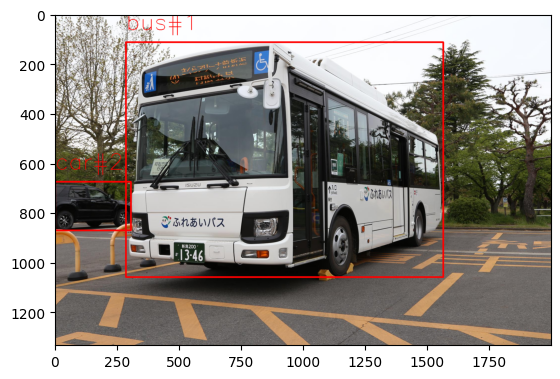

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Open the image file
img_cv2 = cv2.imread(results[0].path)

# Set the font scale and thickness
font_scale = 3
font_thickness = 2

# Loop through each bounding box
i=1
for bbox, cls in zip(coordinate_bbox, classes):
    print(bbox)

    x1, y1, x2, y2 = map(int, bbox)
    color=(0,0,255) # red
    # Draw the bounding box
    cv2.rectangle(img_cv2, (x1, y1), (x2, y2), color, 5)
    cls_text = classes_map.get(int(cls))
    # Put the class label text
    cv2.putText(img_cv2, cls_text+"#"+str(i), (x1, y1 - 50), cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, font_thickness)
    i += 1

# Save the image
cv2.imwrite('/Users/hinomaruc/Desktop/blog/dataset/yolov8/runs/mypredict/sample_bbox.png', img_cv2)


#plt.imshow(cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB))
# Convert the color from BGR to RGB
img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)

# Use matplotlib to display the image
plt.imshow(img_rgb)

# Show the axes
plt.axis('on')

# Show the image
plt.show()


In [51]:
boxes.xywh

tensor([[ 924.2347,  586.4233, 1277.1128,  946.5497],
        [ 153.0672,  773.5651,  305.6873,  195.5817]])

In [22]:
boxes.conf

tensor([0.9516, 0.7463, 0.6134])

In [23]:
boxes.cls

tensor([0., 0., 0.])

In [ ]:
from google.colab.patches import cv2_imshow

plotted = result[0].plot()
plotted = result[1].plot()
cv2_imshow(plotted)


image 1/1 /content/chugatasu.JPG: 448x640 1 car, 1 bus, 189.7ms
Speed: 5.1ms preprocess, 189.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


aaa: tensor([[ 924.2347,  586.4233, 1277.1128,  946.5497],
        [ 153.0672,  773.5651,  305.6873,  195.5817]])
[[924.2347412109375, 586.4232788085938, 1277.11279296875, 946.5496826171875], [153.06719970703125, 773.5651245117188, 305.68731689453125, 195.5816650390625]]


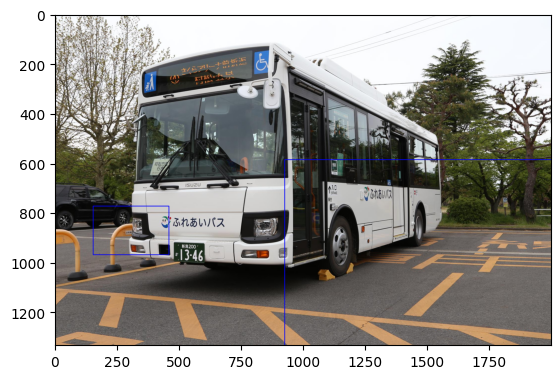

In [27]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.pt')  # pretrained YOLOv8n model

# Run batched inference on a list of images
#results = model(['im1.jpg', 'im2.jpg'], stream=True)  # return a generator of Results objects
results = model(img_path[2], stream=False)  # return a generator of Results objects


# Process results generator
for result in results:
    boxes = result.boxes  # Boxes object for bbox outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Class probabilities for classification outputs
    print(f"aaa: {boxes.xywh}")

img = cv2.imread(img_path[2])
bounding_boxes = boxes.xywh.tolist()
print(bounding_boxes)

# Draw the bounding boxes on the image
for box in bounding_boxes:
    x, y, w, h = box
    cv2.rectangle(img, (int(x), int(y)), (int(x + w), int(y + h)), (255, 0, 0), 2)  # blue color, 2 px thickness

# Convert color from BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(img_rgb)
plt.show()

In [34]:
# Run inference on an image with YOLOv8n
!yolo predict model=yolov8n.pt source='/content/chugatasu.JPG' save_crop=True save_conf=True save_txt=True

Ultralytics YOLOv8.0.141 🚀 Python-3.10.6 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients

image 1/1 /content/chugatasu.JPG: 448x640 1 car, 1 bus, 239.4ms
Speed: 6.1ms preprocess, 239.4ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict2
1 label saved to runs/detect/predict2/labels
